# U-Net 3D CT Segmentation

This notebook implements a 3D U-Net model for segmenting pelvis from CT scans.

## Setup and Imports

First, let's check our environment and dependencies.

In [ ]:
!pip install SimpleITK
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm
from google.colab import drive
from google.colab import files


# Print versions for reproducibility
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
print(f"SimpleITK version: {sitk.__version__}")
print(f"NumPy version: {np.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 25.3 MB/s eta 0:00:00
PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device: NVIDIA A100-SXM4-40GB
SimpleITK version: 2.4.0
NumPy version: 1.26.4


## 2. Data Exploration
Let's examine our dataset structure and visualize some samples.

In [ ]:
# Define paths
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/data'
BASE_DIR = '/content/drive/MyDrive/ct_segmentation'  # Create a dedicated project folder

# Create organized subdirectories
PATHS = {
    'data': f'{BASE_DIR}/data',
    'models': f'{BASE_DIR}/models',
    'checkpoints': f'{BASE_DIR}/checkpoints',
    'results': f'{BASE_DIR}/results',
    'logs': f'{BASE_DIR}/logs'
}

# Create all directories
for path in PATHS.values():
    os.makedirs(path, exist_ok=True)

# Update data paths
images_path = os.path.join(PATHS['data'], 'PENGWIN_CT_train_images')
labels_path = os.path.join(PATHS['data'], 'PENGWIN_CT_train_labels')

# Update model save paths
MODEL_SAVE_PATH = os.path.join(PATHS['models'], 'best_unet_model.pth')
CHECKPOINT_DIR = PATHS['checkpoints']

# List and count files
image_files = sorted([f for f in os.listdir(images_path) if f.endswith('.mha')])
label_files = sorted([f for f in os.listdir(labels_path) if f.endswith('.mha')])

Mounted at /content/drive


## 3. Dataset Implementation

In [ ]:
class CTScanDataset(Dataset):
    def __init__(self, images_path, labels_path, patch_size=(128, 128, 128), stride=(26, 26, 26)):
        self.image_paths = sorted([os.path.join(images_path, fname)
                                for fname in os.listdir(images_path)
                                if fname.endswith('.mha')])
        self.label_paths = sorted([os.path.join(labels_path, fname)
                                for fname in os.listdir(labels_path)
                                if fname.endswith('.mha')])

        self.patch_size = patch_size
        self.stride = stride

        assert len(self.image_paths) == len(self.label_paths)

    def extract_patches(self, image, label):
        """Extract patches from image and label"""
        patches_img = []
        patches_label = []

        D, H, W = image.shape

        # Calculate steps for each dimension
        d_steps = range(0, D - self.patch_size[0] + 1, self.stride[0])
        h_steps = range(0, H - self.patch_size[1] + 1, self.stride[1])
        w_steps = range(0, W - self.patch_size[2] + 1, self.stride[2])

        # If image is smaller than patch size, pad it
        if D < self.patch_size[0]:
            d_steps = [0]
        if H < self.patch_size[1]:
            h_steps = [0]
        if W < self.patch_size[2]:
            w_steps = [0]

        for d in d_steps:
            for h in h_steps:
                for w in w_steps:
                    # Extract patches
                    d_end = min(d + self.patch_size[0], D)
                    h_end = min(h + self.patch_size[1], H)
                    w_end = min(w + self.patch_size[2], W)

                    patch_img = image[d:d_end, h:h_end, w:w_end]
                    patch_label = label[d:d_end, h:h_end, w:w_end]

                    # Pad if necessary
                    if patch_img.shape != self.patch_size:
                        pad_d = self.patch_size[0] - patch_img.shape[0]
                        pad_h = self.patch_size[1] - patch_img.shape[1]
                        pad_w = self.patch_size[2] - patch_img.shape[2]

                        patch_img = np.pad(patch_img,
                                         ((0, pad_d), (0, pad_h), (0, pad_w)),
                                         mode='constant')
                        patch_label = np.pad(patch_label,
                                           ((0, pad_d), (0, pad_h), (0, pad_w)),
                                           mode='constant')

                    patches_img.append(patch_img)
                    patches_label.append(patch_label)

        return np.array(patches_img), np.array(patches_label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and label
        image = sitk.GetArrayFromImage(sitk.ReadImage(self.image_paths[idx])).astype(np.float32)
        label = sitk.GetArrayFromImage(sitk.ReadImage(self.label_paths[idx])).astype(np.float32)

        # Preprocessing
        image = np.clip(image, -1000, 1000)
        image = (image + 1000) / 2000
        label = (label > 0).astype(np.float32)

        # Extract patches
        patches_img, patches_label = self.extract_patches(image, label)

        # Randomly select one patch during training
        patch_idx = np.random.randint(len(patches_img))

        # Add channel dimension
        image_patch = np.expand_dims(patches_img[patch_idx], axis=0)
        label_patch = np.expand_dims(patches_label[patch_idx], axis=0)

        return torch.tensor(image_patch), torch.tensor(label_patch)

In [ ]:
def validate(model, val_image_path, val_label_path, patch_size=(128, 128, 128)):
    """
    Validate model performance on a single validation image
    Returns Dice score
    """
    model.eval()
    device = next(model.parameters()).device

    # Load validation image and label
    val_image = sitk.GetArrayFromImage(sitk.ReadImage(val_image_path)).astype(np.float32)
    val_label = sitk.GetArrayFromImage(sitk.ReadImage(val_label_path)).astype(np.float32)

    # Preprocess
    val_image = np.clip(val_image, -1000, 1000)
    val_image = (val_image + 1000) / 2000
    val_label = (val_label > 0).astype(np.float32)

    # Predict using sliding window
    prediction = predict_volume(model, val_image, patch_size=patch_size)

    # Apply sigmoid and threshold
    prediction = (prediction > 0.5).astype(np.float32)

    # Calculate Dice score
    intersection = np.sum(prediction * val_label)
    dice_score = (2. * intersection) / (np.sum(prediction) + np.sum(val_label) + 1e-7)

    return dice_score

def predict_volume(model, image, patch_size=(128, 128, 128), stride=(26, 26, 26)):
    """Predict segmentation using sliding window approach"""
    model.eval()
    device = next(model.parameters()).device

    D, H, W = image.shape
    output = np.zeros_like(image, dtype=np.float32)
    weight = np.zeros_like(image, dtype=np.float32)

    # Calculate steps
    d_steps = range(0, D - patch_size[0] + 1, stride[0])
    h_steps = range(0, H - patch_size[1] + 1, stride[1])
    w_steps = range(0, W - patch_size[2] + 1, stride[2])

    # Handle edge cases
    if D < patch_size[0]:
        d_steps = [0]
    if H < patch_size[1]:
        h_steps = [0]
    if W < patch_size[2]:
        w_steps = [0]

    with torch.no_grad():
        for d in d_steps:
            for h in h_steps:
                for w in w_steps:
                    # Extract patch
                    d_end = min(d + patch_size[0], D)
                    h_end = min(h + patch_size[1], H)
                    w_end = min(w + patch_size[2], W)

                    patch = image[d:d_end, h:h_end, w:w_end]

                    # Initialize padding values before potential assignment
                    pad_d, pad_h, pad_w = 0, 0, 0

                    # Pad if necessary
                    if patch.shape != patch_size:
                        pad_d = patch_size[0] - patch.shape[0]
                        pad_h = patch_size[1] - patch.shape[1]
                        pad_w = patch_size[2] - patch.shape[2]

                        patch = np.pad(patch,
                                     ((0, pad_d), (0, pad_h), (0, pad_w)),
                                     mode='constant')

                    # Predict
                    patch = torch.tensor(patch).float().unsqueeze(0).unsqueeze(0).to(device)
                    pred = torch.sigmoid(model(patch)).cpu().numpy()[0, 0]

                    # Unpad if necessary
                    if pad_d > 0 or pad_h > 0 or pad_w > 0:
                        pred = pred[:d_end-d, :h_end-h, :w_end-w]

                    # Add to output with weight
                    output[d:d_end, h:h_end, w:w_end] += pred
                    weight[d:d_end, h:h_end, w:w_end] += 1

    # Average overlapping predictions
    output = np.divide(output, weight, where=weight!=0)
    return output

## 4. Model Architecture Visualization

In [ ]:
class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        def up_conv(in_ch, out_ch):
            return nn.ConvTranspose3d(in_ch, out_ch, kernel_size=2, stride=2)

        # Encoder
        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = conv_block(512, 1024)

        # Decoder
        self.upconv4 = up_conv(1024, 512)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = up_conv(512, 256)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = up_conv(256, 128)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = up_conv(128, 64)
        self.decoder1 = conv_block(128, 64)

        self.output = nn.Conv3d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Implementation remains the same as in your original code
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.upconv4(b)
        d4 = self.decoder4(torch.cat((e4, d4), dim=1))
        d3 = self.upconv3(d4)
        d3 = self.decoder3(torch.cat((e3, d3), dim=1))
        d2 = self.upconv2(d3)
        d2 = self.decoder2(torch.cat((e2, d2), dim=1))
        d1 = self.upconv1(d2)
        d1 = self.decoder1(torch.cat((e1, d1), dim=1))

        return self.output(d1)


show the parameter of the model

In [ ]:

    def print_model_summary(model):
        """Print model architecture summary"""
        print("Model Architecture:")
        print("------------------")
        total_params = 0
        for name, param in model.named_parameters():
            param_count = param.numel()
            total_params += param_count
            print(f"{name}: {list(param.shape)} ({param_count:,} parameters)")
        print(f"\nTotal parameters: {total_params:,}")

    # Initialize model and print summary
    model = UNet3D(in_channels=1, out_channels=1)
    print_model_summary(model)

Model Architecture:
------------------
encoder1.0.weight: [64, 1, 3, 3, 3] (1,728 parameters)
encoder1.0.bias: [64] (64 parameters)
encoder1.2.weight: [64, 64, 3, 3, 3] (110,592 parameters)
encoder1.2.bias: [64] (64 parameters)
encoder2.0.weight: [128, 64, 3, 3, 3] (221,184 parameters)
encoder2.0.bias: [128] (128 parameters)
encoder2.2.weight: [128, 128, 3, 3, 3] (442,368 parameters)
encoder2.2.bias: [128] (128 parameters)
encoder3.0.weight: [256, 128, 3, 3, 3] (884,736 parameters)
encoder3.0.bias: [256] (256 parameters)
encoder3.2.weight: [256, 256, 3, 3, 3] (1,769,472 parameters)
encoder3.2.bias: [256] (256 parameters)
encoder4.0.weight: [512, 256, 3, 3, 3] (3,538,944 parameters)
encoder4.0.bias: [512] (512 parameters)
encoder4.2.weight: [512, 512, 3, 3, 3] (7,077,888 parameters)
encoder4.2.bias: [512] (512 parameters)
bottleneck.0.weight: [1024, 512, 3, 3, 3] (14,155,776 parameters)
bottleneck.0.bias: [1024] (1,024 parameters)
bottleneck.2.weight: [1024, 1024, 3, 3, 3] (28,311,552 p

## 5. Training Configuration and Progress Tracking

In [ ]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Use paths from PATHS dictionary
images_path = os.path.join(PATHS['data'], 'PENGWIN_CT_train_images')
labels_path = os.path.join(PATHS['data'], 'PENGWIN_CT_train_labels')

# Hyperparameters
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
BATCH_SIZE = 4

# Dataset and DataLoader setup
train_transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)),
    transforms.Normalize((0.5,), (0.5,))
])

# Initialize dataset with patch-based approach
train_dataset = CTScanDataset(
    images_path=images_path,
    labels_path=labels_path,
    patch_size=(128, 128, 128),
    stride=(26, 26, 26)
)

# Rest of your training code remains the same
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model initialization
model = UNet3D(in_channels=1, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

class TrainingMonitor:
    def __init__(self):
        self.train_losses = []
        self.current_epoch = 0

    def update(self, epoch_loss):
        self.train_losses.append(epoch_loss)
        self.current_epoch += 1

    def plot_progress(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.title('Training Progress')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()
        plt.show()

    def print_stats(self):
        print(f"Current epoch: {self.current_epoch}")
        print(f"Best loss: {min(self.train_losses):.4f}")
        print(f"Current loss: {self.train_losses[-1]:.4f}")

# Initialize training monitor
monitor = TrainingMonitor()

Using device: cuda


## 5. Training Loop

Starting training...


Epoch 1/50: 100%|██████████| 25/25 [11:32<00:00, 27.71s/it, loss=0.24]


Saved new best model with loss: 0.2855


Epoch 2/50: 100%|██████████| 25/25 [04:41<00:00, 11.25s/it, loss=0.19]


Saved new best model with loss: 0.1141


Epoch 3/50: 100%|██████████| 25/25 [03:59<00:00,  9.56s/it, loss=0.072]


Saved new best model with loss: 0.1129


Epoch 4/50: 100%|██████████| 25/25 [03:24<00:00,  8.16s/it, loss=0.0507]


Saved new best model with loss: 0.0693


Epoch 5/50: 100%|██████████| 25/25 [03:21<00:00,  8.08s/it, loss=0.0971]


Validation Dice score: 0.7410
Saved new best model with Dice score: 0.7410


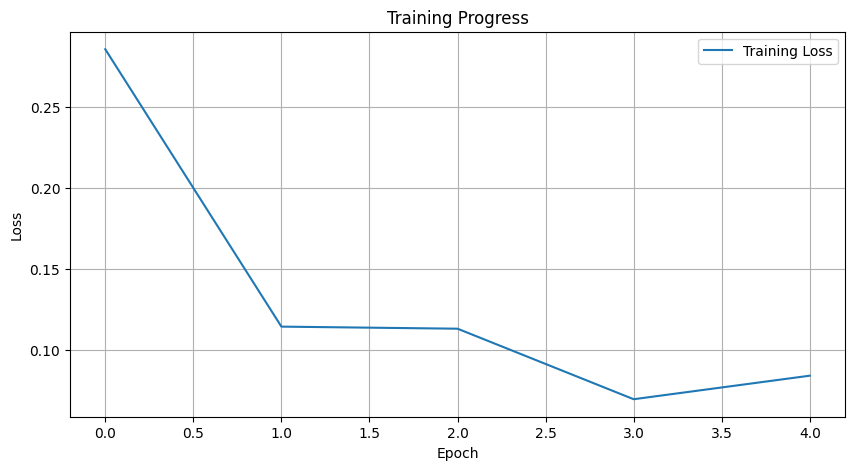

Current epoch: 5
Best loss: 0.0693
Current loss: 0.0838


Epoch 8/50: 100%|██████████| 25/25 [03:23<00:00,  8.15s/it, loss=0.0172]


Saved new best model with loss: 0.0633


Epoch 10/50: 100%|██████████| 25/25 [03:32<00:00,  8.51s/it, loss=0.0943]


Validation Dice score: 0.7424
Saved new best model with Dice score: 0.7424


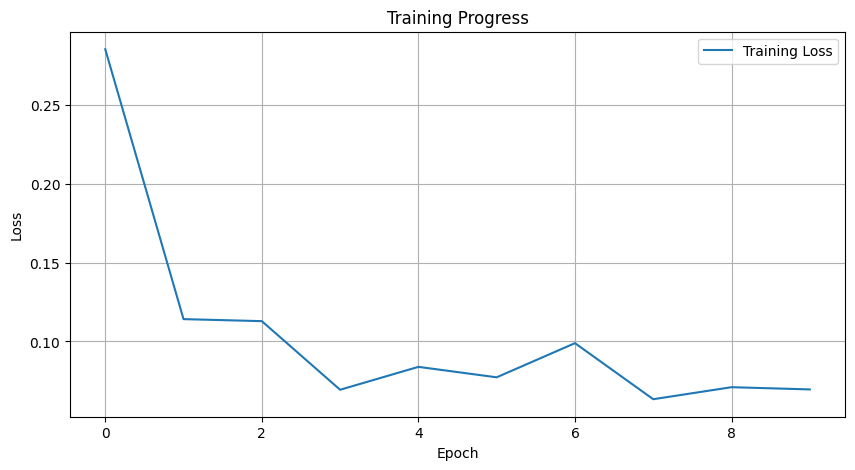

Current epoch: 10
Best loss: 0.0633
Current loss: 0.0695


Epoch 12/50: 100%|██████████| 25/25 [03:27<00:00,  8.28s/it, loss=0.101]


Saved new best model with loss: 0.0615


Epoch 13/50: 100%|██████████| 25/25 [03:25<00:00,  8.23s/it, loss=0.0315]


Saved new best model with loss: 0.0603


Epoch 15/50: 100%|██████████| 25/25 [03:28<00:00,  8.32s/it, loss=0.185]


Validation Dice score: 0.7341


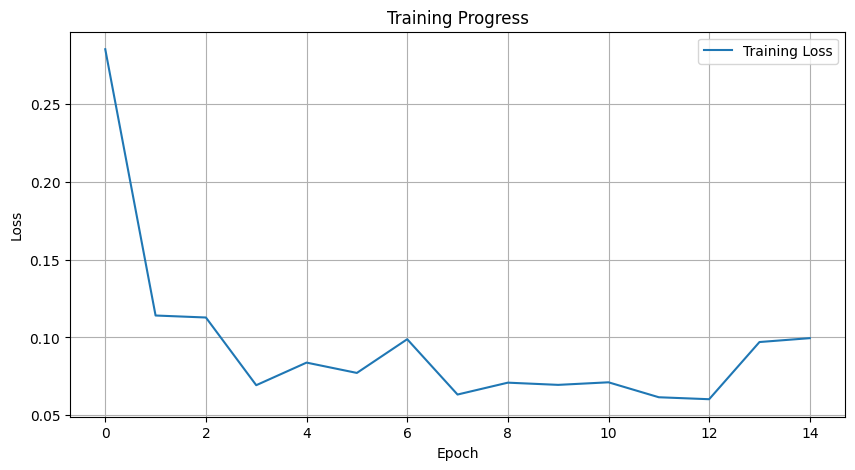

Current epoch: 15
Best loss: 0.0603
Current loss: 0.0996


Epoch 20/50: 100%|██████████| 25/25 [03:29<00:00,  8.38s/it, loss=0.000143]


Validation Dice score: 0.7194


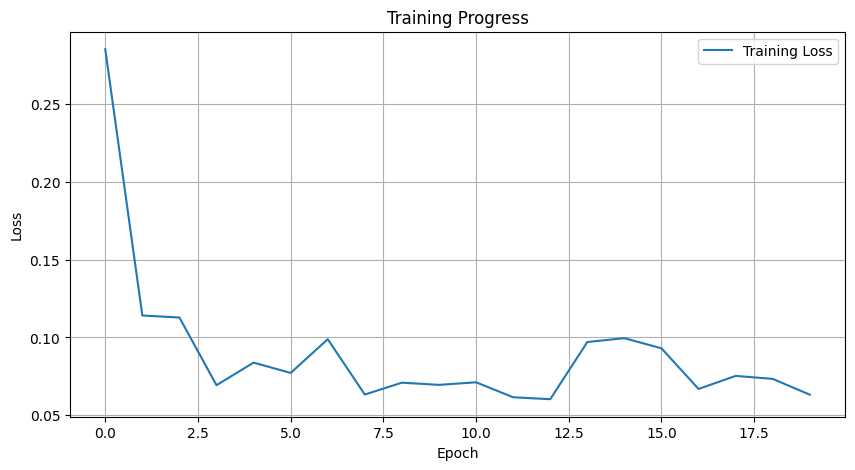

Current epoch: 20
Best loss: 0.0603
Current loss: 0.0632


Epoch 25/50: 100%|██████████| 25/25 [03:25<00:00,  8.23s/it, loss=0.391]


Validation Dice score: 0.0000


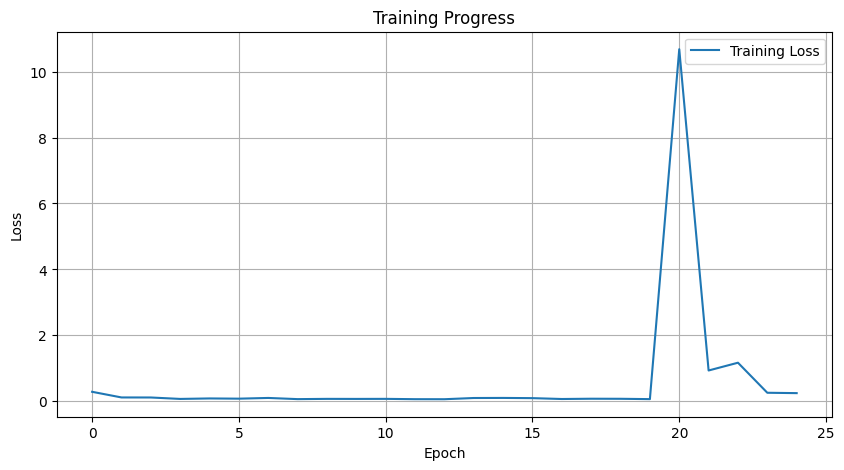

Current epoch: 25
Best loss: 0.0603
Current loss: 0.2451


Epoch 30/50: 100%|██████████| 25/25 [03:22<00:00,  8.10s/it, loss=0.318]


Validation Dice score: 0.0000


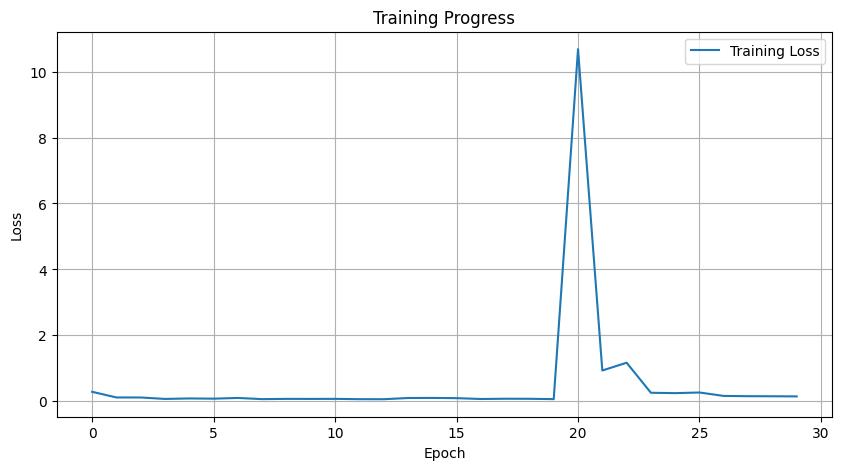

Current epoch: 30
Best loss: 0.0603
Current loss: 0.1460


Epoch 35/50: 100%|██████████| 25/25 [03:26<00:00,  8.26s/it, loss=0.116]


Validation Dice score: 0.0000


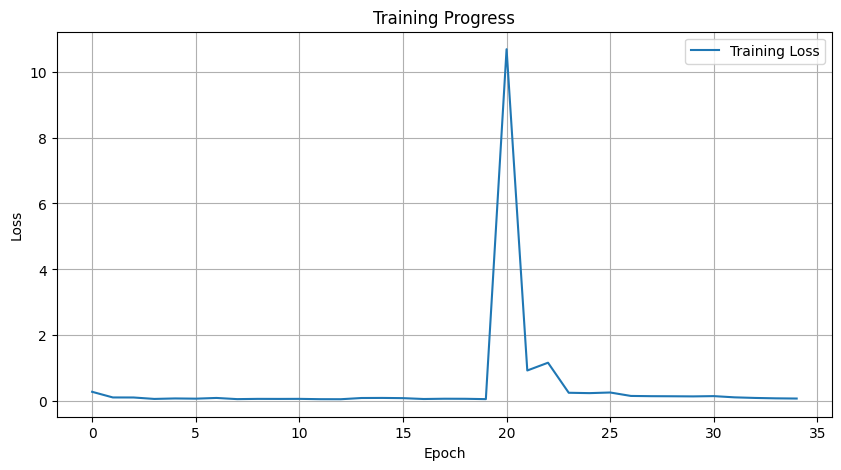

Current epoch: 35
Best loss: 0.0603
Current loss: 0.0810


Epoch 38/50: 100%|██████████| 25/25 [03:24<00:00,  8.17s/it, loss=0.0716]


Saved new best model with loss: 0.0599


Epoch 40/50: 100%|██████████| 25/25 [03:24<00:00,  8.20s/it, loss=0.179]


Validation Dice score: 0.0000


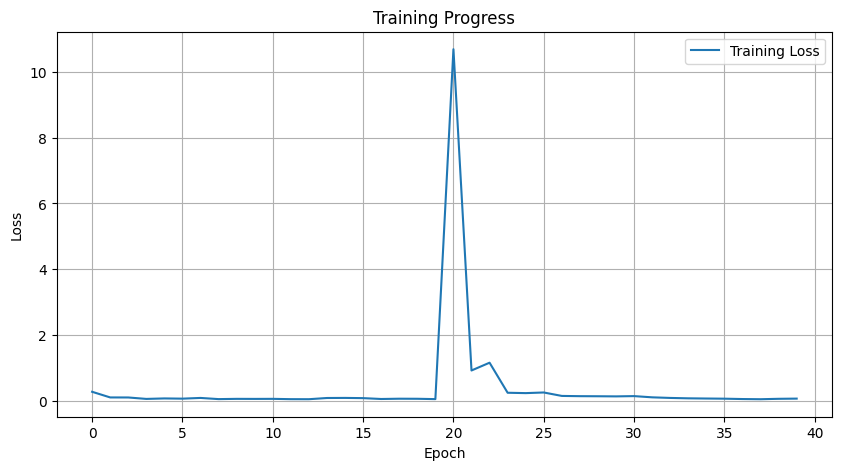

Current epoch: 40
Best loss: 0.0599
Current loss: 0.0783


Epoch 45/50: 100%|██████████| 25/25 [03:26<00:00,  8.25s/it, loss=0.0858]


Validation Dice score: 0.0000


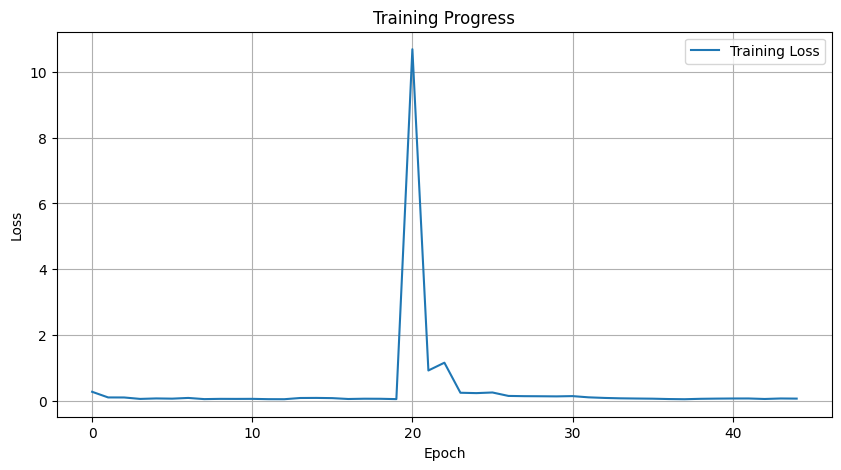

Current epoch: 45
Best loss: 0.0599
Current loss: 0.0784


Epoch 50/50: 100%|██████████| 25/25 [03:27<00:00,  8.31s/it, loss=0.0624]


Validation Dice score: 0.0000


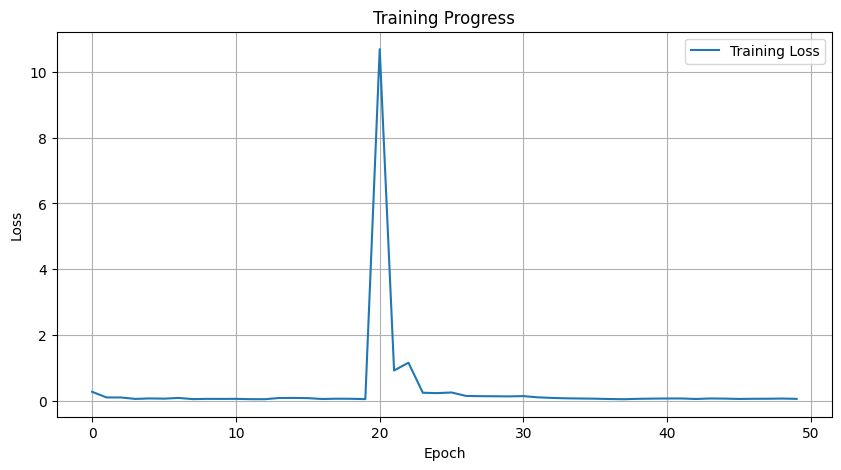

Current epoch: 50
Best loss: 0.0599
Current loss: 0.0705


In [ ]:
# Update save paths at the start
best_model_dice_path = os.path.join(PATHS['models'], 'best_model_dice.pth')
best_model_loss_path = os.path.join(PATHS['models'], 'best_model_loss.pth')

def train_model(model, train_loader, val_image_path, val_label_path, criterion, optimizer, num_epochs, device, monitor):
    best_loss = float('inf')
    best_dice = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Training loop
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for images, masks in pbar:
            images = images.float().to(device)
            masks = masks.float().to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})

        # Calculate average loss for this epoch
        avg_loss = running_loss / len(train_loader)
        monitor.update(avg_loss)

        # Validation (every 5 epochs)
        if (epoch + 1) % 5 == 0:
            dice_score = validate(model, val_image_path, val_label_path)
            print(f"Validation Dice score: {dice_score:.4f}")

            # Save best model based on dice score
            if dice_score > best_dice:
                best_dice = dice_score
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'dice_score': dice_score,
                }, best_model_dice_path)
                print(f"Saved new best model with Dice score: {dice_score:.4f}")

        # Save best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }, best_model_loss_path)
            print(f"Saved new best model with loss: {best_loss:.4f}")

        # Save regular checkpoint
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch+1:03d}.pth')
        torch.save({
            'epoch': epoch,
            'loss': avg_loss,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'dice_score': dice_score if 'dice_score' in locals() else None,
            'best_dice': best_dice,
            'best_loss': best_loss
        }, checkpoint_path)

        # Plot progress every 5 epochs
        if (epoch + 1) % 5 == 0:
            monitor.plot_progress()
            monitor.print_stats()

# Split your data into training and validation sets
all_image_files = sorted(os.listdir(images_path))
all_label_files = sorted(os.listdir(labels_path))

# Use last image for validation
val_image_path = os.path.join(images_path, all_image_files[-1])
val_label_path = os.path.join(labels_path, all_label_files[-1])

# Function to resume training from checkpoint
def resume_training(checkpoint_path, model, optimizer, train_loader, val_image_path, val_label_path, num_epochs, device, monitor):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1

    print(f"Resuming training from epoch {start_epoch}")
    train_model(model, train_loader, val_image_path, val_label_path,
                criterion, optimizer, num_epochs-start_epoch, device, monitor)

# Start training
print("Starting training...")
train_model(model, train_loader, val_image_path, val_label_path,
           criterion, optimizer, NUM_EPOCHS, device, monitor)

# To resume training later, use:
# latest_checkpoint = os.path.join(CHECKPOINT_DIR, 'checkpoint_epoch_XXX.pth')  # Replace XXX with epoch number
# resume_training(latest_checkpoint, model, optimizer, train_loader, val_image_path, val_label_path, NUM_EPOCHS, device, monitor)

## 6. Visualize Training Results

In [ ]:
class TrainingMonitor:
    def __init__(self):
        self.train_losses = []
        self.val_dices = []
        self.current_epoch = 0
        self.plot_dir = PATHS['results']

    def plot_progress(self):
        plt.figure(figsize=(15, 5))

        # Plot training loss
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Training Loss')
        plt.title('Training Loss Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()

        # Plot validation dice if available
        if self.val_dices:
            plt.subplot(1, 2, 2)
            plt.plot(range(0, len(self.val_dices)*5, 5), self.val_dices, label='Validation Dice')
            plt.title('Validation Dice Over Time')
            plt.xlabel('Epoch')
            plt.ylabel('Dice Score')
            plt.grid(True)
            plt.legend()

        plt.tight_layout()

        # Save plot
        plot_path = os.path.join(self.plot_dir, f'training_progress_epoch_{self.current_epoch:03d}.png')
        plt.savefig(plot_path)
        plt.show()
        plt.close()